# **MRI Brain Tumor Classification CNN Model**
 We'll build a CNN that can classify MRI brain scans into categories like:
 - **Glioma Tumor**
 - **Meningioma Tumor**
 - **Pituitary Tumor**
 - **No Tumor**

# **1.**  **Stages of Development**

| **Stage** | **Focus**              | **Description**                                                      |
|------------|------------------------|----------------------------------------------------------------------|
| **S1**     | Image Preprocessing    | Load and prepare MRI images for CNN training                         |
| **S2**     | CNN Basics             | Build a simple CNN from scratch and understand how it works           |
| **S3**     | Transfer Learning      | Use a pre-trained model (VGG16/ResNet) for higher accuracy            |
| **S4**     | Fine-Tuning & Evaluation | Improve accuracy, visualize performance, and save the model         |


## **1.1.** **S1: Image Preprocessing**
**Step 1: Dataset**

- We’ll use this dataset from Kaggle:

-  Brain Tumor MRI Dataset

- URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

**Step 2: Import Libraries**


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Explanation:**

- os → lets us work with file paths

- numpy → for mathematical operations

- matplotlib.pyplot → for visualizing images

- ImageDataGenerator → used to load, resize, normalize, and augment images

**Step 3: Set Dataset Path** **(Mount Google Drive)**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_path = '/content/drive/MyDrive/datasets/Training'
test_path = '/content/drive/MyDrive/datasets/Testing'

**Step 4: Load & Preprocess Images**

In [9]:
# ImageDataGenerator automatically normalizes pixel values to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),   # resize all images to 224x224
    batch_size=32,
    class_mode='categorical'  # multi-class classification
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


**Explanation:**

- **rescale=1./255:** converts pixel values from 0–255 → 0–1 (normalization helps CNN learn faster)

- **target_size=(224, 224):** resizes all MRI images to a fixed size

- **batch_size=32:** processes 32 images at a time (for memory efficiency)

- class_mode= **'categorical':** because we have 4 classes

**Step 5: Visualizing a Few Images**

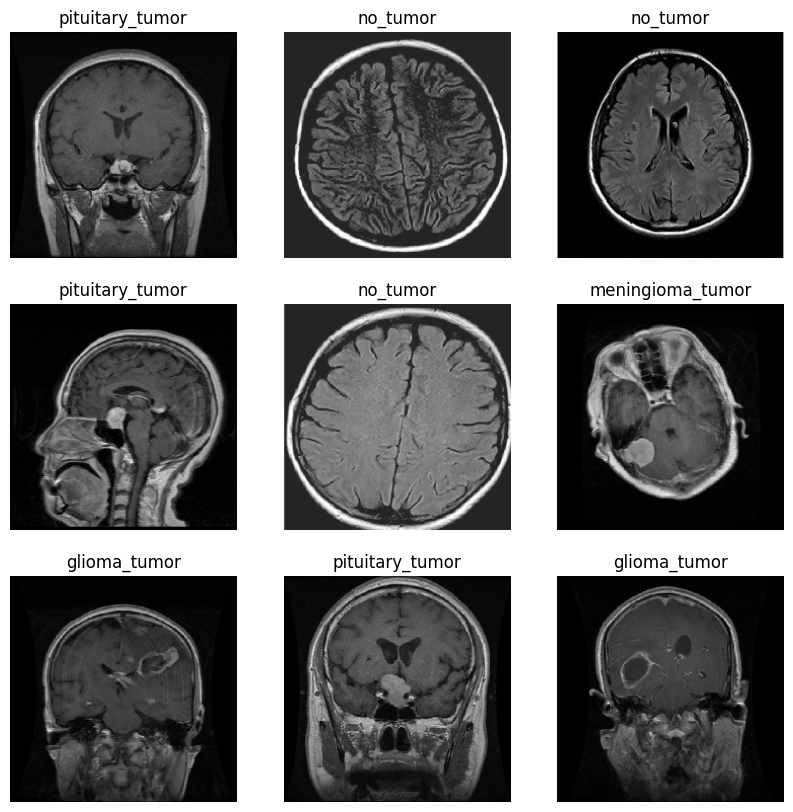

In [10]:
x, y = next(train_set)  # take one batch of images
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    plt.title(list(train_set.class_indices.keys())[np.argmax(y[i])])
    plt.axis('off')
plt.show()


**Explanation:**

- **next(train_set)** → gives us a batch of images and labels

- **plt.subplot(3,3,i+1)** → creates a 3×3 grid

- **train_set.class_indices** → maps folder names to numeric labels

- **np.argmax(y[i])** → finds which class each image belongs to

## **1.2.** **S2: CNN Architecture & Training**

**Concept: What is a CNN?**

- CNN = Convolutional Neural Network.
It’s a type of deep learning model that learns patterns in images.

- **Key concepts:**

1. **Convolutional Layer:** Applies small filters (3×3, 5×5) that slide over the image to detect features like edges, corners, textures.

2. **Pooling Layer:** Reduces image size (downsampling) to keep important features and reduce computation.

3. **Feature Maps:** The output of convolutional layers — shows which features the CNN detected.

4. **Fully Connected Layers:** At the end, combine all features to make a prediction (like a normal neural network).

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input shape = 224x224 pixels + 3 color channels (RGB)
input_shape = (224, 224, 3)
num_classes = 4  # glioma, meningioma, pituitary, no tumor

# Build a simple CNN model
model = models.Sequential()

# --- First Convolution + Pooling ---
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2,2)))

# --- Second Convolution + Pooling ---
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# --- Third Convolution + Pooling ---
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# --- Flatten and Fully Connected Layers ---
model.add(layers.Flatten())   # convert 2D feature maps to 1D vector
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  # reduce overfitting
model.add(layers.Dense(num_classes, activation='softmax'))  # final layer

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # for multi-class classification
              metrics=['accuracy'])

# Check model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Explanation:**

| **Code** | **Explanation** |
|----------|----------------|
| `Conv2D(32, (3,3), activation='relu')` | 32 filters, size 3×3, detect simple features (edges, blobs). ReLU = non-linear activation. |
| `MaxPooling2D((2,2))` | Reduce size by half. Keeps important features, discards unnecessary details. |
| `Flatten()` | Convert 2D feature maps into 1D vector for dense layers. |
| `Dense(128, activation='relu')` | Fully connected layer learns combinations of features. |
| `Dropout(0.4)` | Randomly turns off 40% of neurons during training → prevents overfitting. |
| `Dense(num_classes, activation='softmax')` | Output layer predicts probabilities for each class. |
| `compile(optimizer='adam', loss='categorical_crossentropy')` | Adam optimizer adjusts weights; categorical_crossentropy = loss function for multi-class problems. |


**Train the CNN**

In [13]:
# Train the model
history = model.fit(
    train_set,
    epochs=5,       # start small, increase later
    validation_data=test_set
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 423s 5s/step - accuracy: 0.6643 - loss: 0.7951 - val_accuracy: 0.4772 - val_loss: 1.7365
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.7863 - loss: 0.5231 - val_accuracy: 0.5685 - val_loss: 2.1429
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.8851 - loss: 0.3245 - val_accuracy: 0.6726 - val_loss: 2.4921
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.9153 - loss: 0.2312 - val_accuracy: 0.6599 - val_loss: 2.1516
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9388 - loss: 0.1608 - val_accuracy: 0.7310 - val_loss: 3.2040


**Step 3: Transfer Learning with VGG16**
- **Concept:** **Why Transfer Learning?**

- VGG16 is a pre-trained CNN on ImageNet (millions of images, 1000 classes).

- Its early layers already detect edges, textures, shapes — features useful for MRI scans too.

- We reuse the pre-trained layers (freeze them) and train only the final layers for our 4-class MRI dataset.

- Later, we can fine-tune top layers to adapt the model better to MRI images.

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

**Load Preprocessed Data**

In [15]:
# Data generators with rescaling + augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # required for VGG16
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


**Explanation:**

- **preprocess_input:** scales images the way VGG16 expects.

- **rotation_range, width_shift_range, etc.:** data augmentation to prevent overfitting.

- **class_mode='categorical':** multi-class classification.

**Load VGG16 Base Model**

In [16]:
# Load VGG16 without the top layer (we'll add our own)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers so weights are not updated initially
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Explanation:**

- **weights=**'imagenet': use pre-trained weights.

- **include_top=False:** remove final classification layer (we’ll add a 4-class output).

- **trainable=False:** prevents changing pre-trained weights during first training phase.

## **1.3.** **S3: Build Transfer Learning**

In [17]:
model = models.Sequential()

# Pre-trained base
model.add(base_model)

# Global average pooling: reduces output from feature maps to 1D vector
model.add(layers.GlobalAveragePooling2D())

# Fully connected layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

# Final output layer for 4 classes
model.add(layers.Dense(4, activation='softmax'))

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Explanation:**

- **GlobalAveragePooling2D():** converts 3D feature maps into 1D vector → reduces parameters.

- **Dropout(0.4):** prevents overfitting.

- **Dense(4, activation='softmax'):** 4-class output for multi-class MRI classification.

- **Adam(1e-4):** learning rate small enough for stable training with transfer learning.

**Train the Model (Head Only)**

In [19]:
# Early stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=5,
    callbacks=[es]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 709ms/step - accuracy: 0.3179 - loss: 3.3218 - val_accuracy: 0.4137 - val_loss: 1.9952
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 534ms/step - accuracy: 0.5312 - loss: 1.6747 - val_accuracy: 0.4619 - val_loss: 1.7951
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 542ms/step - accuracy: 0.6551 - loss: 1.0519 - val_accuracy: 0.5152 - val_loss: 1.6202
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 535ms/step - accuracy: 0.7107 - loss: 0.8798 - val_accuracy: 0.5330 - val_loss: 1.6296
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 538ms/step - accuracy: 0.7331 - loss: 0.7618 - val_accuracy: 0.5508 - val_loss: 1.5781


## **1.4.** **S4: Fine Tuning**

In [21]:
# Unfreeze top layers of VGG16
base_model.trainable = True

# Freeze lower layers (optional: keep first 10-15 layers frozen)
for layer in base_model.layers[:15]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
history_ft = model.fit(
    train_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[es]
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 586ms/step - accuracy: 0.7742 - loss: 0.6186 - val_accuracy: 0.6244 - val_loss: 1.4048
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 552ms/step - accuracy: 0.8307 - loss: 0.4667 - val_accuracy: 0.6802 - val_loss: 1.3665
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 541ms/step - accuracy: 0.8745 - loss: 0.3535 - val_accuracy: 0.7081 - val_loss: 1.3205
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 545ms/step - accuracy: 0.8916 - loss: 0.2964 - val_accuracy: 0.7234 - val_loss: 1.2925
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 554ms/step - accuracy: 0.9074 - loss: 0.2680 - val_accuracy: 0.7513 - val_loss: 1.3172
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 550ms/step - accuracy: 0.9177 - loss: 0.2261 - val_accuracy: 0.7462 - val_loss: 1.3204
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 543ms/step - accuracy: 0.9193 - loss: 0.2031 - val_accuracy: 0.7817 - val_loss: 1.3149
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 545ms/step - accuracy: 0.9396 - loss: 0.1767 - val_accu

**Explanation:**

- We now allow some pre-trained layers to adjust for MRI-specific features.

- **learning_rate=1e-5:** very small → prevents destroying pre-trained weights.

- Fine-tuning usually improves accuracy slightly.

**Evaluate Model**

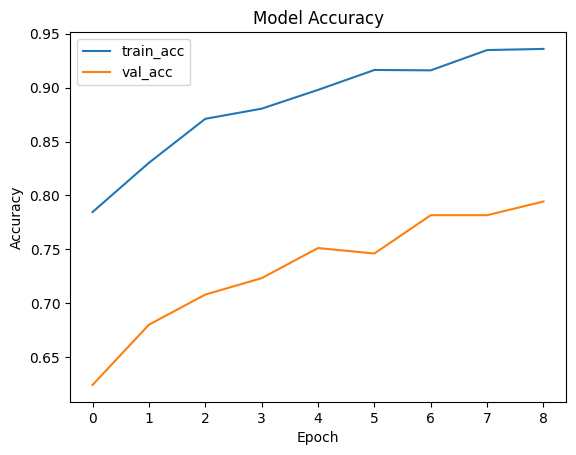

In [22]:
# Accuracy and Loss
import matplotlib.pyplot as plt

plt.plot(history_ft.history['accuracy'], label='train_acc')
plt.plot(history_ft.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Testing the Multi-Class MRI Brain Tumor Classifier**

After training and evaluating the model on validation data, the next step is to **test the model on unseen images**. This will give us the real-world performance.

---

## **1 Evaluate Overall Accuracy on Test Set**

We can calculate **accuracy and loss** on the test set using `model.evaluate()`.


In [23]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5420 - loss: 2.4558
Test Accuracy: 72.34%
Test Loss: 1.2925


**Explanation:**
- `model.evaluate()` computes the loss and accuracy on unseen images.
- `test_acc` is the percentage of correctly classified images in the test set.
- `test_loss` shows how well the model predicts (lower is better).

---

## **2️. Confusion Matrix & Classification Report**

We can check **which classes are correctly predicted** and where the model makes mistakes.


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict class probabilities
y_pred_probs = model.predict(test_set)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_set.classes

# Class names
class_names = list(test_set.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step
Confusion Matrix:
[[33 29 19 19]
 [ 6 93  2 14]
 [ 0  6 91  8]
 [ 0  6  0 68]]
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.33      0.47       100
meningioma_tumor       0.69      0.81      0.75       115
        no_tumor       0.81      0.87      0.84       105
 pituitary_tumor       0.62      0.92      0.74        74

        accuracy                           0.72       394
       macro avg       0.74      0.73      0.70       394
    weighted avg       0.75      0.72      0.70       394



**Explanation:**
- `confusion_matrix` shows correct vs misclassified images for each class.
- `classification_report` gives:
  - **Precision** → proportion of correct predictions for a class
  - **Recall** → proportion of actual class images correctly predicted (important in medical imaging)
  - **F1-score** → balance between precision and recall
- Helps identify which tumor type the model struggles with.

---

## **3 Visualize Predictions on Test Images**

Let's **see some predictions vs true labels** for a few test images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


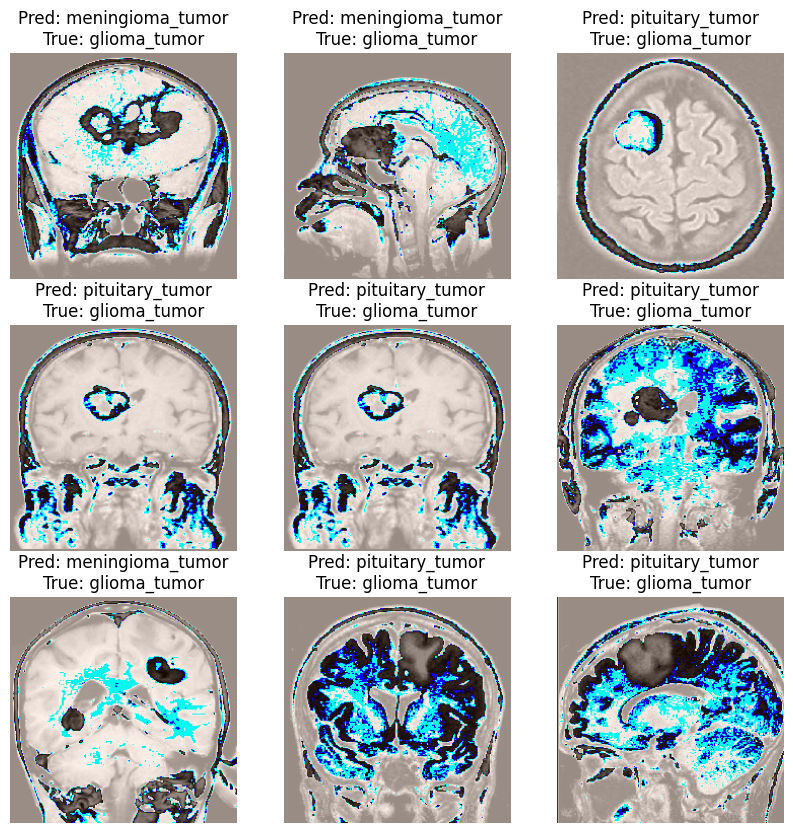

In [25]:
import matplotlib.pyplot as plt

# Get one batch of test images
x_test, y_test = next(test_set)

# Predict class labels for the batch
y_pred_batch = np.argmax(model.predict(x_test), axis=1)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[i].astype('uint8'))
    plt.title(f"Pred: {class_names[y_pred_batch[i]]}\nTrue: {class_names[np.argmax(y_test[i])]}")
    plt.axis('off')
plt.show()

**Explanation:**
- `x_test[i]` → displays the MRI image.
- `y_pred_batch[i]` → predicted tumor type.
- `y_test[i]` → true label.
- Visual inspection is useful to **see where the model works and fails**.
